In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
import json

# Analyse von Filmdaten

Ziel ist es herauszufinden, ob anhand verschiedener Filmdaten wie z.B. Budget, Genre, Bewertung usw. auf die Einspielergebnisse geschlossen werden kann, die ein Film erzielt hat. Da die Eingabe- und Ausgabewerte bekannt sind, handelt es sich um *supervised learning*. Das Einspielergebnis kann als stetige Variable betrachtet werden, weshalb es sich um ein *Regressions-Problem* handelt.

## Auswahl des Algorithmus

Von den vorhandenen Algorithmen wurde der Random-Forest-Algorithmus ausgewählt, da er eine Regressionsanalyse erlaubt. Es wurde sich gegen die lineare Regression entschieden, da nicht davon ausgegangen wird, dass das Einspielergebniss in einem linearen Verhältnis zu den anderen Filmdaten steht. Die k-Means- und k-Nearest-Neighbor-Algorithm wurden nicht gewählt, da sie für Clustering bzw. Klassifizierung gedacht sind.

## Übersicht über die verwendeten Daten

Die verwendeten Film-Daten wurden von [Kaggle][1] bezogen und sind in zwei CSV-Dateien mit jeweils 4803 Datensätzen aufgeteilt. Es sind nominal skalierte Werte wie z.B. die original Sprache oder die Film-Genre ohne natürliche Rangfolge vorhanden. Auch sind kardinal skalierte Werte, die sich in eine Reihenfolge bringen lassen und dessen Unterschied berechnet werden kann, gegeben. Beispiele dafür sind das Budget, die Popularität oder auch das Einspielergebnis. Generell kann das Random Forest Verfahren mit all diesen Werten umgehen. Allerdings unterstüzt die verwendete [scikit-learn-Bibliothek keine kategorischen Daten][2]:

    scikit-learn uses an optimised version of the CART algorithm; however, scikit-learn implementation does not support categorical variables for now.

Solche Werte müssen deshalb vorher in numerische Werte umgewandelt werden.

[1]: https://www.kaggle.com/tmdb/tmdb-movie-metadata
[2]: https://scikit-learn.org/stable/modules/tree.html#tree-algorithms

Zuerst müssen die verwendeten CSV-Dateien hochgeladen werden. Dafür muss folgende Code-Zelle ausgeführt werden.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tmdb_5000_movies.csv to tmdb_5000_movies (1).csv


In [ ]:
movies = pd.read_csv('tmdb_5000_movies.csv', index_col='id')
display(movies.head(1))

,budget,genres,homepage,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
id,,,,,,,,,,,,,,,,,,,
19995,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


## Vorverarbeitung
In einigen Spalte werden nicht vorhandene Werte mit einer 0 angegeben. Damit solche Werte von Pandas [als nicht vorhanden erkannt][1] werden, werden sie durch `np.nan` ersetzt.

[1]: https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html

In [ ]:
movies['budget'] = movies['budget'].replace(0, np.nan)
movies['runtime'] = movies['runtime'].replace(0, np.nan)
movies['revenue'] = movies['revenue'].replace(0, np.nan)

In der `genres`-Spalte befinden sich JSON-kodierte Strings.

In [ ]:
display(movies['genres'].iloc[0])

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

Um diese Werte nutzen zu könenn wird eine neue Tabelle erstellt, die für jeden Film einen Eintrag und für jedes Genre eine Spalte enthält. Die Werte in der Tabelle sind dann entweder 0, wenn der Film nicht dieses Genre hat oder 1 wenn der Film dieses Genre hat.

In [ ]:
# Hilfsvariable um zu erst die JSON Strings zu dekodieren und dann die Genre-Namen zu extrahieren.
genre_names = movies['genres'].apply(json.loads)
genre_names = genre_names.apply(lambda x: [d['name'] for d in x])

mlb = preprocessing.MultiLabelBinarizer()
mlb.fit(genre_names)
genres = pd.DataFrame(mlb.transform(genre_names), index=movies.index, columns=mlb.classes_)

display(genres.iloc[:3])

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,,
19995,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
285,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
206647,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Das Release-Datum soll auch benutzt werden, dafür werden zwei neue Spalten mit Jahr und Monat erstellt da es interessant sein könnte ob der Monat der Veröffentlichung eine Rolle spielt.

In [ ]:
movies['release_month'] = movies['release_date'].apply(lambda x: pd.to_datetime(x).month)
movies['release_year'] = movies['release_date'].apply(lambda x: pd.to_datetime(x).year)

Alle Features, die für das Model verwendet werden sollen, werden in einem DataFrame zusammengefasst und alle Zeilen mit nicht vorhandenen Werten entfernt.

In [ ]:
used_features = movies[['budget', 'revenue', 'runtime', 'release_month', 'release_year', 'popularity']].join(genres)
used_features = used_features.dropna()

# Erstellung und Training des Models

Zuerst werden die zu verwendenden Daten in Trainings- und Testdaten aufgeteilt. Danach wird noch die gesuchte Zielvariable (revenue) von den restlichen Daten getrennt.

In [ ]:
train, test = train_test_split(used_features, test_size=0.2, random_state=0)

train_revenue = train.pop('revenue')
test_revenue = test.pop('revenue')

Über den `max_samples`-Parameter kann festgelegt werden, wie viele Samples (%) je Entscheidungsbaum verwendet werden sollen. Der Paramter kann einen großen Einfluss auf das Ergebniss haben.

Score: 0.668673630059138


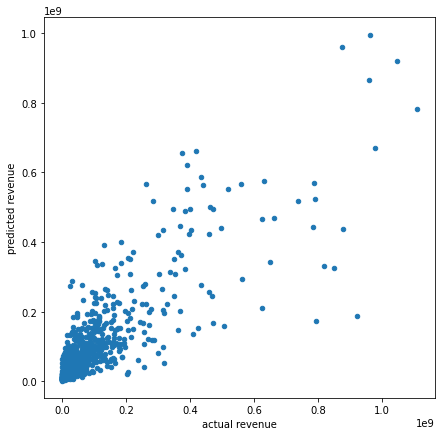

In [ ]:
model = RandomForestRegressor(max_samples=0.1, random_state=0)

model.fit(train, train_revenue)

predicted_revenue = model.predict(test)

print('Score:', model.score(test, test_revenue))

df = pd.DataFrame({'actual revenue': test_revenue, 'predicted revenue': predicted_revenue})
g = df.plot(x='actual revenue', y='predicted revenue', kind='scatter', figsize=(7, 7))

Falls man nun den "max-samples"-Parameter erhöht, kann man erkennen das bei manchen Filmen der vorhergesagte Ertrag steigt. Zum Beispiel sieht man das daran das ab 20 prozentiger Nutzung von Samples in Entscheidungsbäumen drei Filme bereits über 1.0 und bei 1.2 liegen.

Score: 0.6543243624360295


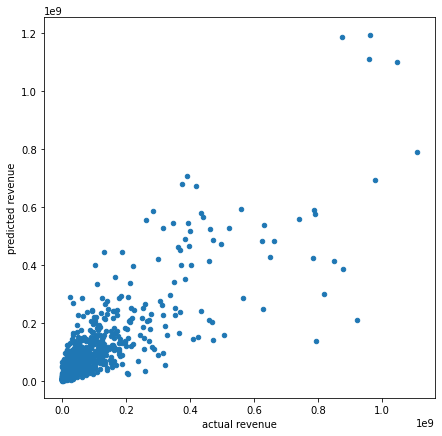

In [ ]:
model = RandomForestRegressor(max_samples=0.2, random_state=1)

model.fit(train, train_revenue)

predicted_revenue = model.predict(test)

print('Score:', model.score(test, test_revenue))

df = pd.DataFrame({'actual revenue': test_revenue, 'predicted revenue': predicted_revenue})
g = df.plot(x='actual revenue', y='predicted revenue', kind='scatter', figsize=(7, 7))

Ab einer Nutzung von 40 Prozent der Samples steigt das Maximum bis auf 1.4. Man kann zudem erkennen das sich die Werte von 0 bis 0.8 immer weniger streuen.

Score: 0.6526965357534599


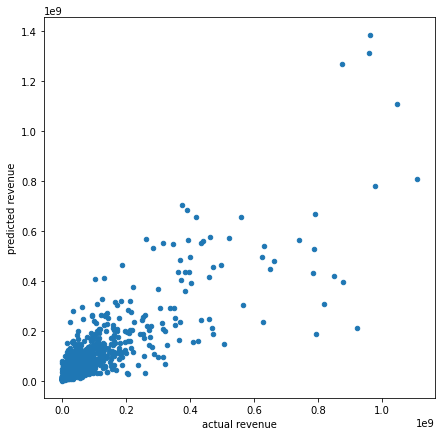

In [ ]:
model = RandomForestRegressor(max_samples=0.4, random_state=1)

model.fit(train, train_revenue)

predicted_revenue = model.predict(test)

print('Score:', model.score(test, test_revenue))

df = pd.DataFrame({'actual revenue': test_revenue, 'predicted revenue': predicted_revenue})
g = df.plot(x='actual revenue', y='predicted revenue', kind='scatter', figsize=(7, 7))

Bei einer Nutzung von 70, 80 und 90 Prozent steigt das Maximum über 1.4 und 1.5 bis fast auf 1.6. Sobald man alle Samples innerhalb eines Entscheidungsbaumes nutzt ist jeder vorhergesagte Ertrag der selbe, da alle Entscheidungsbäume mit denselben Testdaten erstellt werden.

Score: -0.00013560691435654526


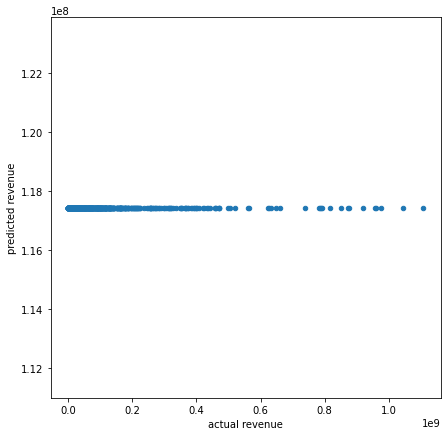

In [ ]:
model = RandomForestRegressor(max_samples=1, random_state=1)

model.fit(train, train_revenue)

predicted_revenue = model.predict(test)

print('Score:', model.score(test, test_revenue))

df = pd.DataFrame({'actual revenue': test_revenue, 'predicted revenue': predicted_revenue})
g = df.plot(x='actual revenue', y='predicted revenue', kind='scatter', figsize=(7, 7))

Als Fazit dazu kann man sagen, dass durch eine höhere Anzahl an benutzten Samples die Varianz des Modells erhöht wird. Das bedeutet mit einer sehr hohen Anzahl wird das Modell zu sehr an die Trainingsdaten angepasst und deswegen wird die Vorhersage für die Testdaten stärker abweichen.